# Creating Your Own LLM Agent

Salman Naqvi  
Monday, 24 November 2025

# Creating Your Own LLM Agent

In this notebook, I’ll show you how simple LLM “agents” are, that
they’re just LLMs in a while loop calling functions, and how to
implement a tool-loop yourself using the
[Lisette](https://lisette.answer.ai/) and
[toolslm](https://answerdotai.github.io/toolslm/) libraries.

## What are Agents?

**“An AI agent is just an LLM in a while loop.”**

That’s it. The LLM requests to run a function (or in other words, the
tool), you run it, give back the result, and repeat until the LLM no
longer requests. No fancy frameworks needed.

### The Core Loop

At its core, it’s simple 4 step loop:

1.  Send message + available tools to the LLM
2.  LLM responds with either the answer OR tool request
3.  If tool is requested: execute the relevant function and add the
    result to the chat history
4.  Go back to step 1.

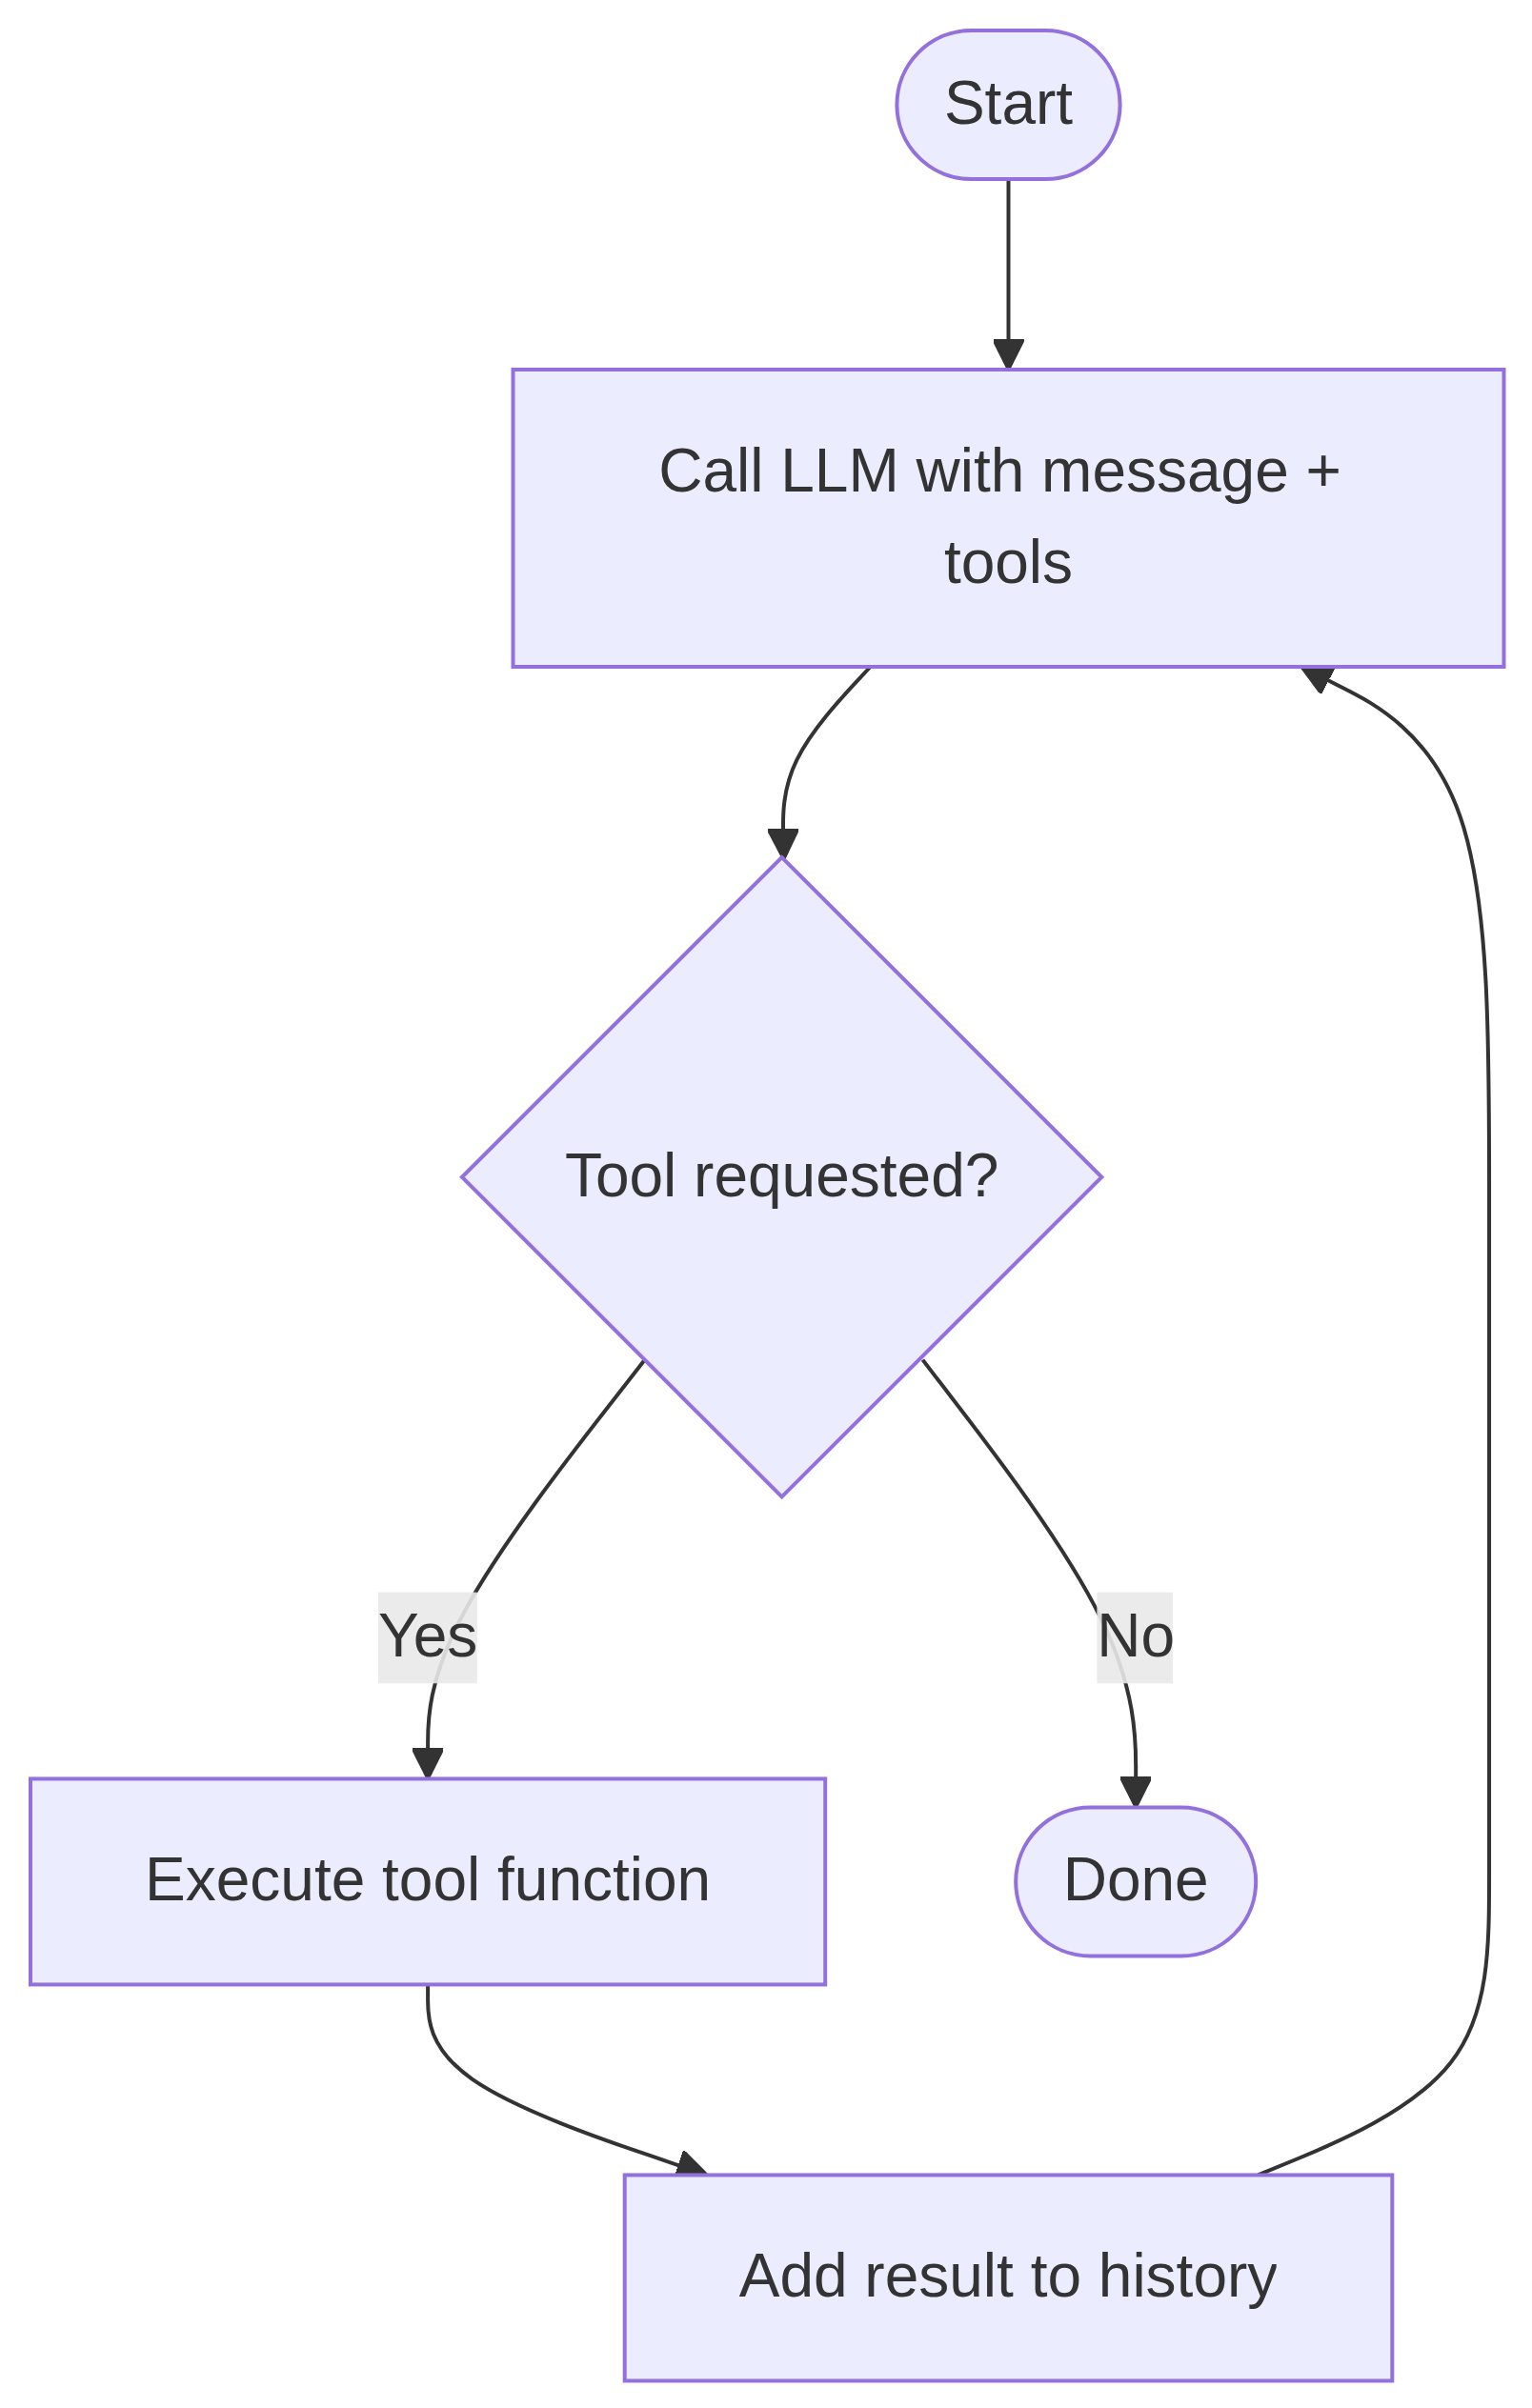

### Walkthrough

#### Step 1: Send Message and Available Tools to LLM

To do this, we first need to setup the tools by: - Tossing all the tools
into a list - Defining the metadata about those tools - Making the tools
available in a “namespace” through which they can directly be called.

Let’s first define two tools.

In [ ]:
def multer(a:float,b:float)->float:
    'Take the product of two numbers'
    return a*b
multer(2,3)

6

In [ ]:
def pow(a:float,b:float)->float:
    'Return a to the power of b'
    return a**b
pow(2,3)

8

And then add it to the list of available tools.

In [ ]:
tools = [multer,pow]; tools

[<function __main__.multer(a: float, b: float) -> float>,
 <function __main__.pow(a: float, b: float) -> float>]

We’ll now create the metadata about this tool.

In [ ]:
from lisette import *

[Lisette](https://lisette.answer.ai/) is a wonderful library that
abstracts away a lot of the boilerplate when working the LLMs in Python.
The library is a wrapper around LiteLLM.

Later in the notebook, I’ll demonstrate how to use Lisette’s `Chat`
class directly to make tool calls with an LLM. For now, I’m using some
of the library’s other functions.

In [ ]:
schemas = [lite_mk_func(t) for t in tools]; schemas

[{'type': 'function',
  'function': {'name': 'multer',
   'description': 'Take the product of two numbers\n\nReturns:\n- type: number',
   'parameters': {'type': 'object',
    'properties': {'a': {'type': 'number', 'description': ''},
     'b': {'type': 'number', 'description': ''}},
    'required': ['a', 'b']}}},
 {'type': 'function',
  'function': {'name': 'pow',
   'description': 'Return a to the power of b\n\nReturns:\n- type: number',
   'parameters': {'type': 'object',
    'properties': {'a': {'type': 'number', 'description': ''},
     'b': {'type': 'number', 'description': ''}},
    'required': ['a', 'b']}}}]

In [ ]:
??lite_mk_func

I’ll now define the namespace.

In [ ]:
from toolslm.funccall import mk_ns

[toolslm](https://answerdotai.github.io/toolslm/) is a helper library
used by Lisette.

In [ ]:
ns = mk_ns(tools); ns

{'multer': <function __main__.multer(a: float, b: float) -> float>,
 'pow': <function __main__.pow(a: float, b: float) -> float>}

In [ ]:
??mk_ns

#### Step 2: Make the First API Call

We’ll now send a message to the LLM endpoint asking it to complete a
somewhat complex calculation.

In [ ]:
from fastcore.all import *
os.environ['MOONSHOT_API_BASE'] = 'https://api.moonshot.cn/v1'

Here I’ve just changed my API end-point from
`'https://api.moonshot.ai/v1'` to `'https://api.moonshot.cn/v1'` as my
API key is only compatible with servers based in China.

In [ ]:
from litellm import completion
hist = [{'role': 'user', 'content': 'Calculate 2*2353**5*1/2'}]
r = completion(model='moonshot/kimi-k2-0711-preview', messages=hist, tools=schemas); r

In [ ]:
print(r)

ModelResponse(id='chatcmpl-6923a5f5ce7148a79dfc95ba', created=1763943925, model='moonshot/kimi-k2-0711-preview', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I need to calculate 2 * 2353^5 * 1/2.\n\nLet me break this down:\n- First, I'll calculate 2353^5\n- Then multiply by 2\n- Then multiply by 1/2 (which is the same as dividing by 2)\n\nLet me start with 2353^5:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=0, function=Function(arguments='{"a": 2353, "b": 5}', name='pow'), id='pow:0', type='function')], function_call=None, provider_specific_fields={'refusal': None}), provider_specific_fields={})], usage=Usage(completion_tokens=93, prompt_tokens=111, total_tokens=204, completion_tokens_details=None, prompt_tokens_details=None), service_tier=None)

#### Step 3: Check if a Tool Call was Requested

We can see that a tool call was requested.

In [ ]:
r.choices[0].finish_reason

'tool_calls'

#### Step 4: Execute It

All that’s left is, well, to execute it.

In [ ]:
tc = r.choices[0].message.tool_calls[0].to_dict(); tc

{'index': 0,
 'function': {'arguments': '{"a": 2353, "b": 5}', 'name': 'pow'},
 'id': 'pow:0',
 'type': 'function'}

In [ ]:
import json
res = ns[tc['function']['name']](**json.loads(tc['function']['arguments'])); res

72128954282026993

#### Step 5: Build History

In [ ]:
hist.append(r.choices[0].message)
hist.append(mk_tc_result(tc, str(res))); hist

[{'role': 'user', 'content': 'Calculate 2*2353**5*1/2'},
 Message(content="I need to calculate 2 * 2353^5 * 1/2.\n\nLet me break this down:\n- First, I'll calculate 2353^5\n- Then multiply by 2\n- Then multiply by 1/2 (which is the same as dividing by 2)\n\nLet me start with 2353^5:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=0, function=Function(arguments='{"a": 2353, "b": 5}', name='pow'), id='pow:0', type='function')], function_call=None, provider_specific_fields={'refusal': None}),
 {'tool_call_id': 'pow:0',
  'role': 'tool',
  'name': 'pow',
  'content': '72128954282026993'}]

#### And that’s all!

Now we just have to keep looping until the query is solved.

In [ ]:
while r.choices[0].finish_reason!='stop':
    mtcd = r.choices[0].message.tool_calls[0].to_dict()
    o = ns[mtcd['function']['name']](**json.loads(mtcd['function']['arguments']))
    tc_res = mk_tc_result(mtcd, str(o))
    hist.append(r.choices[0].message)
    hist.append(tc_res)
    r = completion(model='moonshot/kimi-k2-0711-preview', messages=hist, tools=schemas)

In [ ]:
r.choices[0].finish_reason

'stop'

In [ ]:
from pprint import pprint as pp
pp(hist)

[{'content': 'Calculate 2*2353**5*1/2', 'role': 'user'},
 Message(content="I need to calculate 2 * 2353^5 * 1/2.\n\nLet me break this down:\n- First, I'll calculate 2353^5\n- Then multiply by 2\n- Then multiply by 1/2 (which is the same as dividing by 2)\n\nLet me start with 2353^5:", role='assistant', tool_calls=[{'index': 0, 'function': {'arguments': '{"a": 2353, "b": 5}', 'name': 'pow'}, 'id': 'pow:0', 'type': 'function'}], function_call=None, provider_specific_fields={'refusal': None}),
 {'content': '72128954282026993',
  'name': 'pow',
  'role': 'tool',
  'tool_call_id': 'pow:0'},
 Message(content="I need to calculate 2 * 2353^5 * 1/2.\n\nLet me break this down:\n- First, I'll calculate 2353^5\n- Then multiply by 2\n- Then multiply by 1/2 (which is the same as dividing by 2)\n\nLet me start with 2353^5:", role='assistant', tool_calls=[{'index': 0, 'function': {'arguments': '{"a": 2353, "b": 5}', 'name': 'pow'}, 'id': 'pow:0', 'type': 'function'}], function_call=None, provider_spec

#### Refactored

In [ ]:
def set_tools(tools):
    tools = listify(tools)
    schemas = [lite_mk_func(t) for t in tools]
    ns = mk_ns(tools)
    return tools, schemas, ns

In [ ]:
def make_query(m,h,s):
    return completion(model=m, messages=h, tools=s)

In [ ]:
def tc2dict(r):
    return r.choices[0].message.tool_calls[0].to_dict()

In [ ]:
def run_tool(tc,ns):
    return ns[tc['function']['name']](**json.loads(tc['function']['arguments']))

In [ ]:
def build_hist(h,r,tc_res):
    h.append(r.choices[0].message)
    h.append(mk_tc_result(r.choices[0].message.tool_calls[0],str(tc_res)))

In [ ]:
hist = [{'role':'user', 'content':'Determine 2*3**4**5'}]
tools, schemas, ns = set_tools([multer,pow])

In [ ]:
r = make_query('moonshot/kimi-k2-0711-preview',hist,schemas); r

In [ ]:
while r.choices[0].finish_reason != 'stop':
    tc = tc2dict(r)
    tc_res = run_tool(tc, ns)
    build_hist(hist,r,tc_res)
    r = make_query('moonshot/kimi-k2-0711-preview', hist, schemas)

In [ ]:
hist

[{'role': 'user', 'content': 'Determine 2*3**4**5'},
 Message(content="I'll solve this step by step, following the order of operations for exponentiation (which is right-associative). The expression 2*3**4**5 means 2×(3^(4^5)).", role='assistant', tool_calls=[{'index': 0, 'function': {'arguments': '{"a": 4, "b": 5}', 'name': 'pow'}, 'id': 'pow:0', 'type': 'function'}], function_call=None, provider_specific_fields={'refusal': None}),
 {'tool_call_id': 'pow:0', 'role': 'tool', 'name': 'pow', 'content': '1024'},
 Message(content="Now I'll calculate 3^1024:", role='assistant', tool_calls=[{'index': 0, 'function': {'arguments': '{"a": 3, "b": 1024}', 'name': 'pow'}, 'id': 'pow:1', 'type': 'function'}], function_call=None, provider_specific_fields={'refusal': None}),
 {'tool_call_id': 'pow:1',
  'role': 'tool',
  'name': 'pow',
  'content': '37339184874102004353295975418486658822540977678373400775063693172207904061726525122999368893880397722046876506543147515810872705459216085858135133698280

## Using Lisette

Lisette is pretty concise. In only 2 lines of code, you can have a
tool-loop up and running

In [ ]:
m = 'moonshot/kimi-k2-0711-preview'
c = Chat(m); c

In [ ]:
r = c('Who are you?')

In [ ]:
from IPython.display import display
c = Chat(m, tools=[multer,pow])
o = c("What's the result of (13**2)*25.5?", max_steps=10, return_all=True); display(*o)

{'tool_call_id': 'pow:0', 'role': 'tool', 'name': 'pow', 'content': '169'}

{'tool_call_id': 'multer:1',
 'role': 'tool',
 'name': 'multer',
 'content': '4309.5'}

The only thing to note here is the `max_steps` parameter. That
determines the length of the tool-loop.

## Conclusion

Building a LLM agent is simpler than it looks seem—at its core, it’s
just a LLM calling functions in a loop.

By repeatedly calling the model, executing requested tools, and feeding
results back into the conversation history, you create a system that can
solve complex multi-step problems.

If you have any comments, questions, suggestions, feedback, criticisms,
or corrections, please do post them down in the comment section below!